In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Create encoder as a nn
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Hidden layer
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # Pass x through layers
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# Create decoder as nn
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        # layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        # Pass x through layers
        h = torch.relu(self.fc1(x))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat


In [6]:
# Combine to make a VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        z = mu + eps*std

        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [7]:
# Define loss
def loss_function(x, x_hat, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return BCE+KLD

In [17]:
# Train
# Hyperparameters
input_dim = 784
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 20
# Data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Model, optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)
# Training loop
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, input_dim)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")

Epoch 1, Loss: 163.11067425130207
Epoch 2, Loss: 121.22905167643229
Epoch 3, Loss: 114.59998597005209
Epoch 4, Loss: 111.61741588541666
Epoch 5, Loss: 109.93026119791666
Epoch 6, Loss: 108.78518489583334
Epoch 7, Loss: 107.91630895182291
Epoch 8, Loss: 107.2635896484375
Epoch 9, Loss: 106.71876049804688
Epoch 10, Loss: 106.33158180338542
Epoch 11, Loss: 105.95767807617187
Epoch 12, Loss: 105.63927916666667
Epoch 13, Loss: 105.40916469726562
Epoch 14, Loss: 105.11169409179688
Epoch 15, Loss: 104.88111061197917
Epoch 16, Loss: 104.71236513671874
Epoch 17, Loss: 104.50783592122396
Epoch 18, Loss: 104.30705724283854
Epoch 19, Loss: 104.21220703125
Epoch 20, Loss: 104.00717913411458


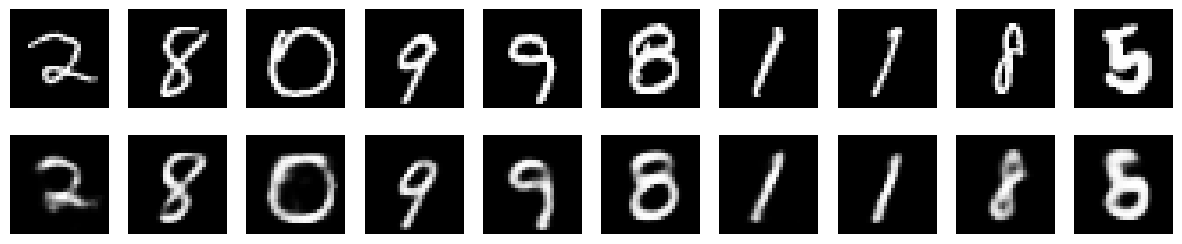

In [18]:
# Test model
# visualizing reconstructed outputs
vae.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.view(-1, input_dim)
    x_hat, _, _ = vae(x)
    x = x.view(-1, 28, 28)
    x_hat = x_hat.view(-1, 28, 28)

    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
        axs[1, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

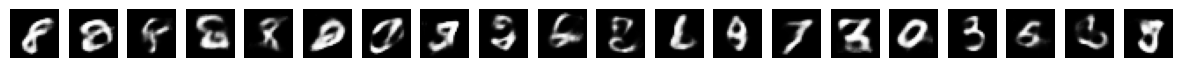

In [19]:
#visualizing generated samples
with torch.no_grad():
    n = 20
    z = torch.randn(n, latent_dim)
    sample = vae.decoder(z)
    sample = sample.view(-1, 28, 28)

    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        axs[i].imshow(sample[i].cpu().numpy(), cmap='gray')
        axs[i].axis('off')
    plt.show()